<a href="https://colab.research.google.com/github/mokshagna2004/Trader-Behavior-vs-Market-Sentiment-Analysis/blob/main/Trader_Behavior_vs_Market_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, roc_auc_score
)
import joblib

hist_path = "historical_data.csv"
fg_path = "fear_greed_index.csv"

hist = pd.read_csv(hist_path, low_memory=False)
fg = pd.read_csv(fg_path, low_memory=False)

def clean_cols(df):
    df = df.copy()
    df.columns = (df.columns.str.strip()
                  .str.replace(' ', '_')
                  .str.replace('.', '')
                  .str.replace('-', '_')
                  .str.lower())
    return df

hist = clean_cols(hist)
fg = clean_cols(fg)

print("Historical data shape:", hist.shape)
print("Fear/Greed data shape:", fg.shape)
print("\nHistorical head:\n", hist.head())
print("\nFear-Greed head:\n", fg.head())


Historical data shape: (205148, 16)
Fear/Greed data shape: (2644, 4)

Historical head:
                                       account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side     timestamp_ist  start_position direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   closed_pnl   

In [5]:
hist['time_parsed'] = pd.to_datetime(hist['timestamp_ist'], errors='coerce', infer_datetime_format=True)
hist['date'] = hist['time_parsed'].dt.date

fg['date_parsed'] = pd.to_datetime(fg['date'], errors='coerce', infer_datetime_format=True)
fg['date_only'] = fg['date_parsed'].dt.date

print("Parsed:", hist['time_parsed'].notna().sum(), "timestamps in trading data")
print("Parsed:", fg['date_parsed'].notna().sum(), "dates in Fear/Greed index")


/tmp/ipython-input-1051091132.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  hist['time_parsed'] = pd.to_datetime(hist['timestamp_ist'], errors='coerce', infer_datetime_format=True)


Parsed: 76856 timestamps in trading data
Parsed: 2644 dates in Fear/Greed index


/tmp/ipython-input-1051091132.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fg['date_parsed'] = pd.to_datetime(fg['date'], errors='coerce', infer_datetime_format=True)


In [6]:
mapping = {
    'extreme fear': 0.0,
    'fear': 0.25,
    'neutral': 0.5,
    'greed': 0.75,
    'extreme greed': 1.0
}

fg['classification'] = fg['classification'].str.lower()
fg['sentiment_value'] = fg['classification'].map(mapping)
fg_daily = fg.groupby('date_only', as_index=False).agg(
    sentiment_value_mean=('sentiment_value', 'mean'),
    sentiment_cat=('classification', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)
fg_daily.rename(columns={'date_only': 'date'}, inplace=True)
print(fg_daily.head())


         date  sentiment_value_mean sentiment_cat
0  2018-02-01                  0.25          fear
1  2018-02-02                  0.00  extreme fear
2  2018-02-03                  0.25          fear
3  2018-02-04                  0.00  extreme fear
4  2018-02-05                  0.00  extreme fear


In [7]:
hist['closed_pnl'] = pd.to_numeric(hist['closed_pnl'], errors='coerce')
hist['profitable'] = (hist['closed_pnl'] > 0).astype(int)

merged = hist.merge(fg_daily, on='date', how='left')
merged['sentiment_value_mean'] = merged['sentiment_value_mean'].fillna(method='ffill').fillna(method='bfill')

print("Merged dataset shape:", merged.shape)
print(merged[['date', 'closed_pnl', 'sentiment_value_mean']].head())


Merged dataset shape: (205148, 21)
         date  closed_pnl  sentiment_value_mean
0  2024-02-12         0.0                  0.75
1  2024-02-12         0.0                  0.75
2  2024-02-12         0.0                  0.75
3  2024-02-12         0.0                  0.75
4  2024-02-12         0.0                  0.75


/tmp/ipython-input-2411017128.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['sentiment_value_mean'] = merged['sentiment_value_mean'].fillna(method='ffill').fillna(method='bfill')


Correlation matrix:
            sentiment   avg_pnl  win_rate
sentiment   1.000000 -0.022236 -0.041429
avg_pnl    -0.022236  1.000000  0.391999
win_rate   -0.041429  0.391999  1.000000


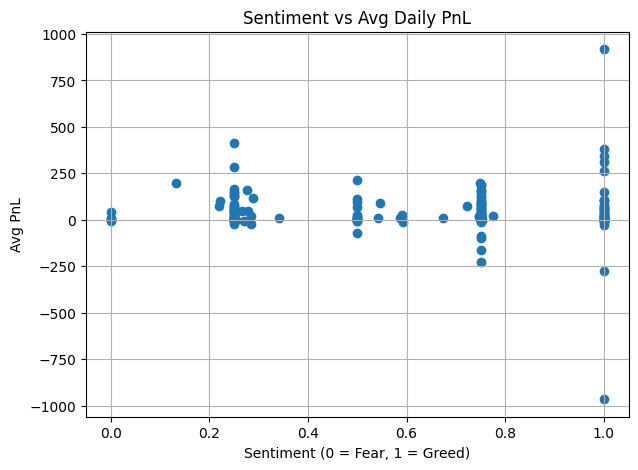

In [8]:
daily_perf = merged.groupby('date', as_index=False).agg(
    avg_pnl=('closed_pnl','mean'),
    win_rate=('profitable','mean'),
    sentiment=('sentiment_value_mean','mean')
)
print("Correlation matrix:\n", daily_perf[['sentiment','avg_pnl','win_rate']].corr())

plt.figure(figsize=(7,5))
plt.scatter(daily_perf['sentiment'], daily_perf['avg_pnl'])
plt.title('Sentiment vs Avg Daily PnL')
plt.xlabel('Sentiment (0 = Fear, 1 = Greed)')
plt.ylabel('Avg PnL')
plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = ['execution_price', 'size_usd', 'fee', 'sentiment_value_mean']
X = merged[features].copy()
y = merged['closed_pnl']

for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')

X = X.fillna(X.median())
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


MAE: 62.31293554107832
RMSE: 921.9314317974968
R²: 0.13459702115517125


In [11]:
Xc = merged[features].copy()
yc = merged['profitable']

Xc = Xc.fillna(Xc.median())
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)

clf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("Precision:", precision_score(yc_test, yc_pred))
print("Recall:", recall_score(yc_test, yc_pred))


Accuracy: 0.8435291250304655
Precision: 0.8275776551553103
Recall: 0.7857773591570024


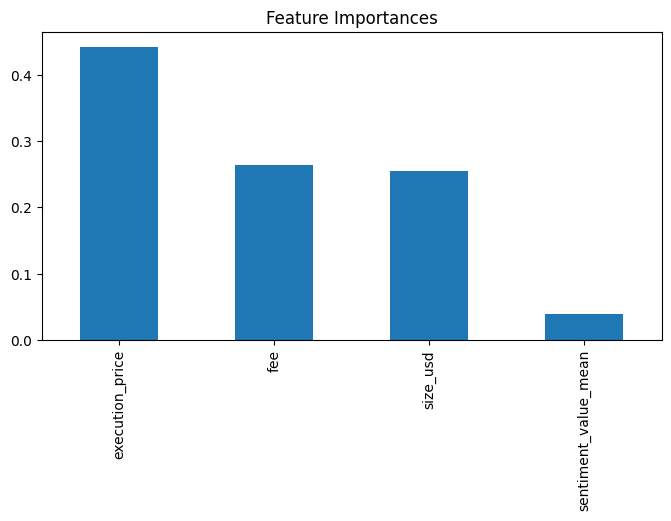

In [13]:
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=Xc.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(8, 4), title='Feature Importances')
plt.show()


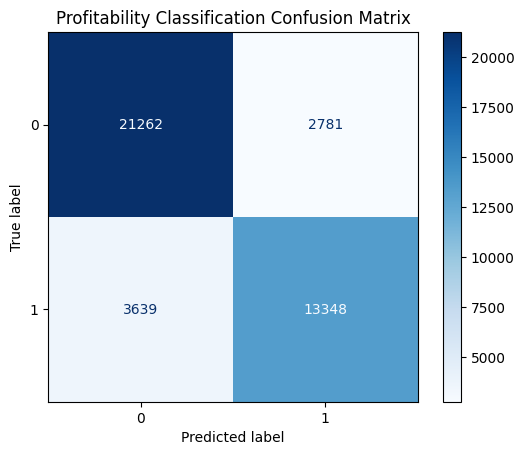

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(yc_test, yc_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Profitability Classification Confusion Matrix")
plt.show()


In [15]:
from sklearn.metrics import roc_auc_score
probs = clf.predict_proba(Xc_test)[:, 1]
auc = roc_auc_score(yc_test, probs)
print("ROC-AUC:", auc)


ROC-AUC: 0.9256547845252658


In [25]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

sample_size = 20000
Xc_small = Xc_train.sample(sample_size, random_state=42)
yc_small = yc_train.loc[Xc_small.index]

clf = RandomForestClassifier(random_state=42, n_jobs=-1)


rs = RandomizedSearchCV(
    clf,
    param_distributions=param_grid,
    n_iter=8,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)


rs.fit(Xc_small, yc_small)

print("\n Best parameters found:")
print(rs.best_params_)

best_clf = rs.best_estimator_
yc_pred = best_clf.predict(Xc_test)

print("\n Performance on full test set:")
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("Precision:", precision_score(yc_test, yc_pred))
print("Recall:", recall_score(yc_test, yc_pred))


Fitting 3 folds for each of 8 candidates, totalling 24 fits

 Best parameters found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

 Performance on full test set:
Accuracy: 0.7440653180599561
Precision: 0.7124885336128948
Recall: 0.6401365750279625


/tmp/ipython-input-1222651033.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['sentiment_label'] = merged[sentiment_col].astype(str).map(label_map).fillna(merged[sentiment_col])
/tmp/ipython-input-1222651033.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_rates.index, y=win_rates.values, palette=colors)


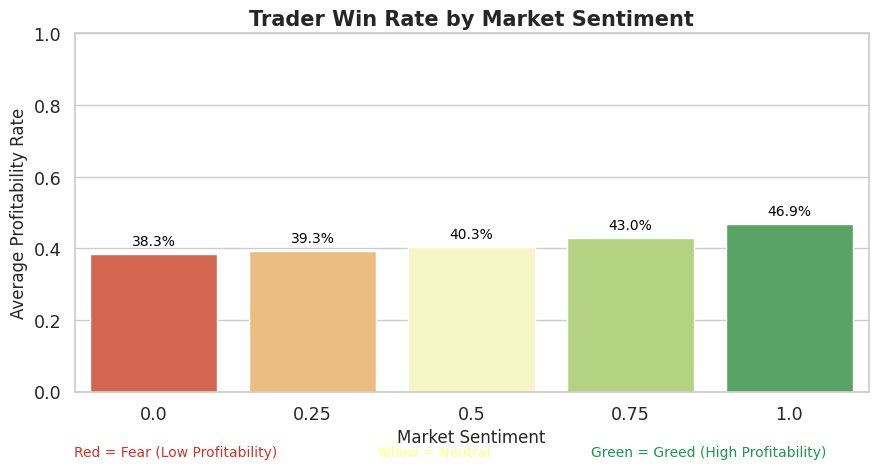

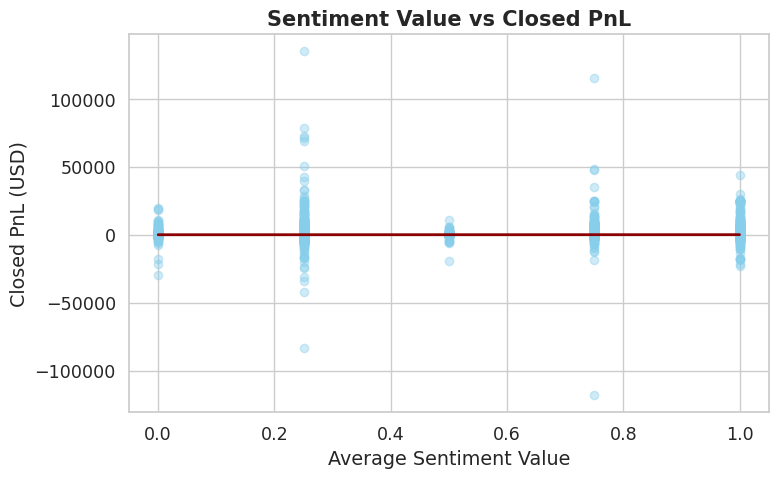

/tmp/ipython-input-1222651033.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='profitable', y='size_usd', data=merged, palette='Set2')


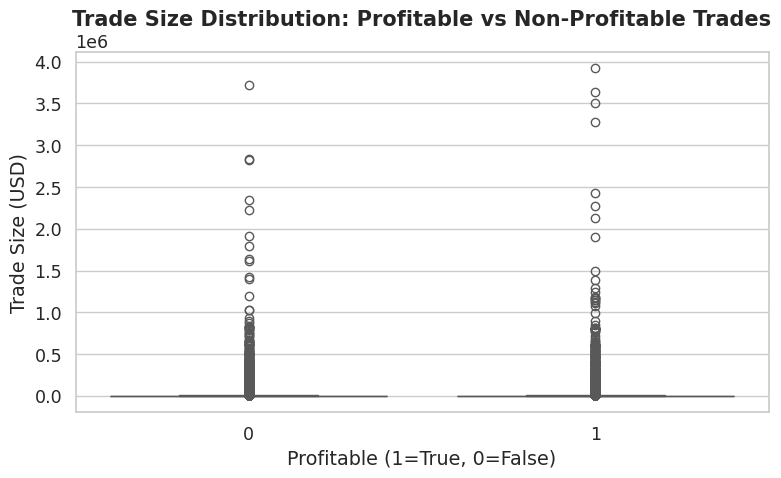

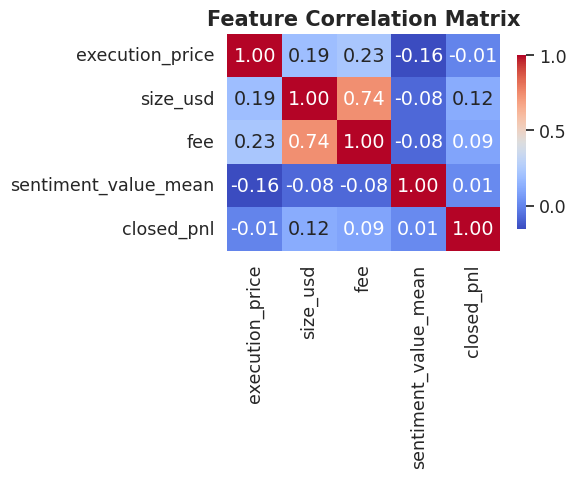

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.15)

sentiment_col = None
for c in merged.columns:
    if 'class' in c.lower() or 'sentiment' in c.lower():
        sentiment_col = c
        break

if sentiment_col:
    label_map = {
        0: 'Extreme Fear', 1: 'Fear', 2: 'Neutral', 3: 'Greed', 4: 'Extreme Greed',
        '0': 'Extreme Fear', '1': 'Fear', '2': 'Neutral', '3': 'Greed', '4': 'Extreme Greed',
        'fear': 'Fear', 'greed': 'Greed', 'neutral': 'Neutral'
    }

    merged['sentiment_label'] = merged[sentiment_col].astype(str).map(label_map).fillna(merged[sentiment_col])

    win_rates = merged.groupby('sentiment_label')['profitable'].mean().sort_values(ascending=True)

    plt.figure(figsize=(9,6))
    colors = sns.color_palette("RdYlGn", len(win_rates))
    sns.barplot(x=win_rates.index, y=win_rates.values, palette=colors)

    plt.title('Trader Win Rate by Market Sentiment', fontsize=15, weight='bold')
    plt.ylabel('Average Profitability Rate', fontsize=12)
    plt.xlabel('Market Sentiment', fontsize=12)
    plt.ylim(0, 1)

    for i, v in enumerate(win_rates.values):
        plt.text(i, v + 0.025, f"{v*100:.1f}%", ha='center', fontsize=10, color='black')

    cmap = sns.color_palette("RdYlGn", as_cmap=True)
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    plt.imshow(gradient, aspect='auto', cmap=cmap, extent=[-0.5, 4.5, -0.12, -0.05])

    plt.text(0.0, -0.18, 'Red = Fear (Low Profitability)', color='#d73027', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.38, -0.18, 'Yellow = Neutral', color='#ffff80', fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.65, -0.18, 'Green = Greed (High Profitability)', color='#1a9850', fontsize=10, transform=plt.gca().transAxes)

    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.show()

else:
    print("Sentiment column not found.")

if 'sentiment_value_mean' in merged.columns and 'closed_pnl' in merged.columns:
    plt.figure(figsize=(8,5))
    sns.regplot(
        data=merged,
        x='sentiment_value_mean', y='closed_pnl',
        scatter_kws={'alpha':0.4, 'color':'skyblue'},
        line_kws={'color':'darkred', 'lw':2}
    )
    plt.title('Sentiment Value vs Closed PnL', fontsize=15, weight='bold')
    plt.xlabel('Average Sentiment Value')
    plt.ylabel('Closed PnL (USD)')
    plt.tight_layout()
    plt.show()

if 'size_usd' in merged.columns and 'profitable' in merged.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='profitable', y='size_usd', data=merged, palette='Set2')
    plt.title('Trade Size Distribution: Profitable vs Non-Profitable Trades', fontsize=15, weight='bold')
    plt.xlabel('Profitable (1=True, 0=False)')
    plt.ylabel('Trade Size (USD)')
    plt.tight_layout()
    plt.show()

corr_cols = ['execution_price', 'size_usd', 'fee', 'sentiment_value_mean', 'closed_pnl']
corr_cols = [c for c in corr_cols if c in merged.columns]

if len(corr_cols) > 1:
    plt.figure(figsize=(6,5))
    corr = merged[corr_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix', fontsize=15, weight='bold')
    plt.tight_layout()
    plt.show()
